In [1]:
!ls

frequent_bigrams.png
frequent_trigrams.png
frequent_words.png
reddit_sarcasm_detection_with_logit.ipynb
train-balanced-sarcasm.csv


In [2]:
# some necessary imports
import os

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from wordcloud import WordCloud, STOPWORDS
from collections import defaultdict

from plotly import tools
from plotly import subplots
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)

import eli5

from IPython.display import Image

import warnings
warnings.filterwarnings("ignore")

In [3]:
train_df = pd.read_csv("train-balanced-sarcasm.csv")

In [4]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


Some comments are missing, so we drop the corresponding rows.

In [6]:
train_df.dropna(subset=["comment"], inplace=True)

The dataset is indeed balanced

In [7]:
label_counts = train_df["label"].value_counts()

In [8]:
label_counts

0    505405
1    505368
Name: label, dtype: int64

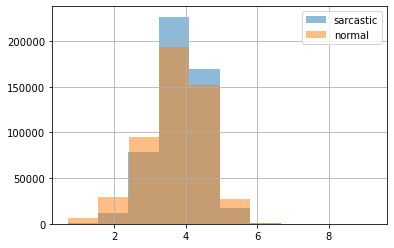

In [9]:
train_df.loc[train_df["label"] == 1, "comment"].str.len().apply(np.log1p).hist(
    label="sarcastic", alpha=0.5)
train_df.loc[train_df["label"] == 0, "comment"].str.len().apply(np.log1p).hist(
    label="normal", alpha=0.5)
plt.legend();

We have the same ditribution sarcastic and non-sarcastic comments, their counts: 50/50, which simplifies our work. 

---

## Preliminary data analysis

Let's start with the "comment" column.

Let's look at the frequently occuring words in the data by creating a word cloud on the 'comment' column.

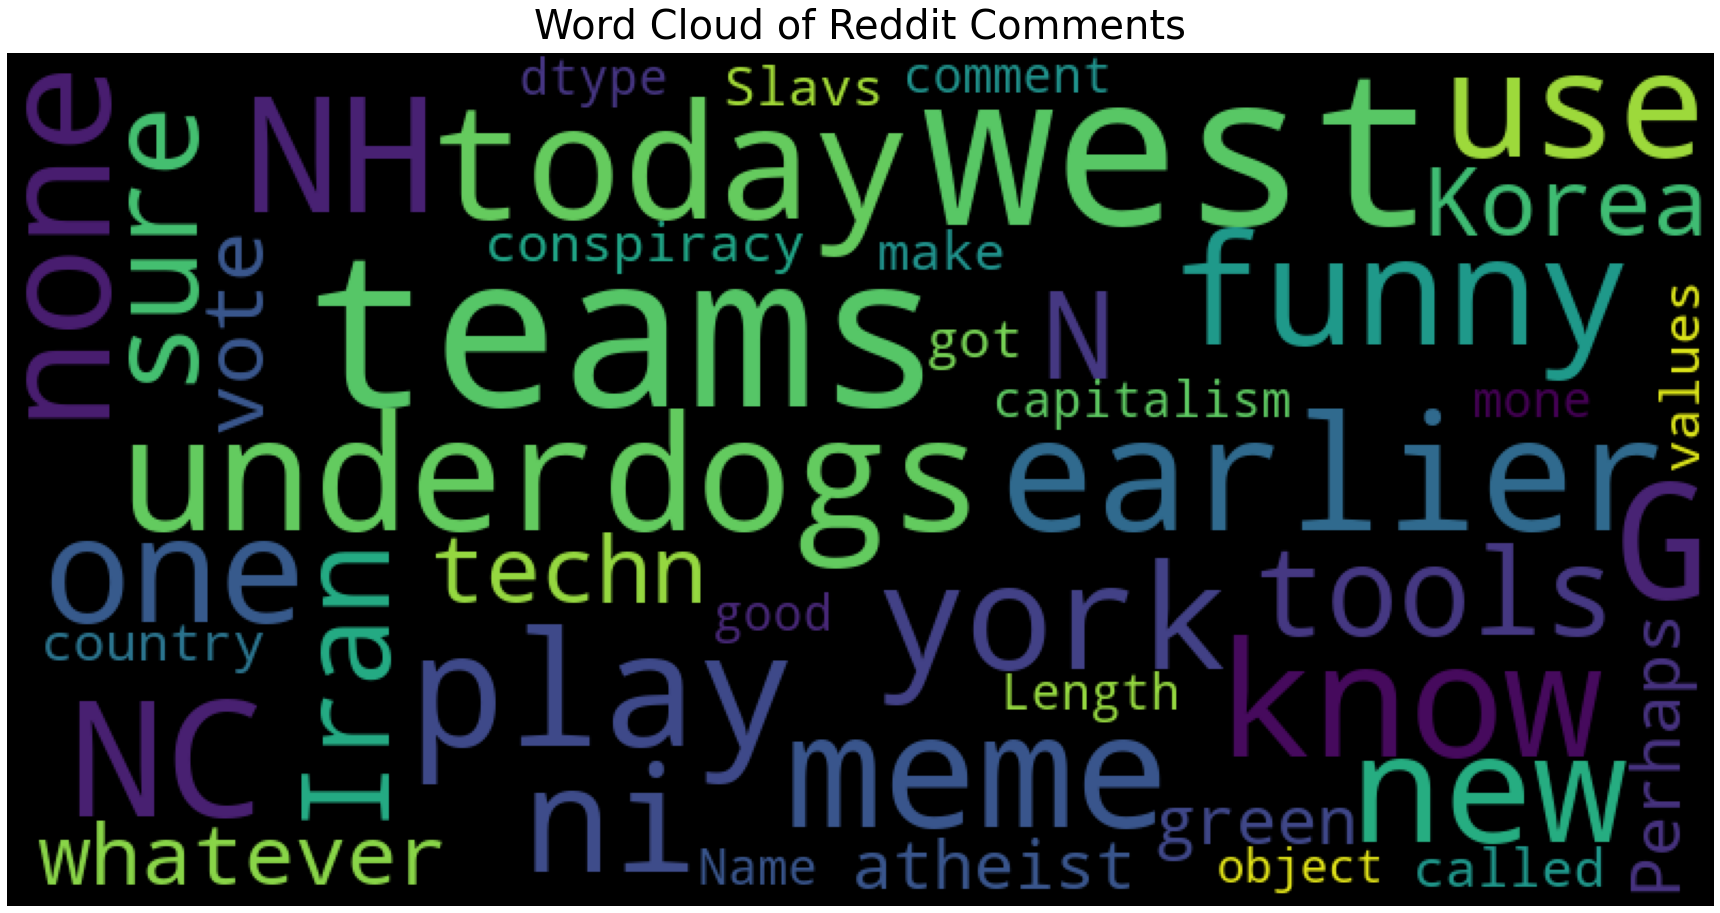

In [10]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), 
                   title=None, title_size=40, image_color=False):
    
    stopwords = set(STOPWORDS)
    
    # more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    # stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
        
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(train_df["comment"], title="Word Cloud of Reddit Comments")

There seem to be a variety of words in there. May be it is a good idea to look at the most frequent words in each of the classes separately.

In [11]:
## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

def get_bar_chart(data, column_text, num_words, color):
    freq_dict = defaultdict(int)
    for sent in data[column_text]:
        for word in generate_ngrams(sent,num_words):
            freq_dict[word] += 1
    fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
    fd_sorted.columns = ["word", "wordcount"]
    trace = horizontal_bar_chart(fd_sorted.head(50), color)
    
    return trace

def show_most_frequent_words(data=None, column_text=None, column_label=None, color="blue", num_words=1):
    
    data1 = data[data[column_label]==1]
    data0 = data[data[column_label]==0]
    
    # Get the bar chart from non-sarcastic comments
    trace0 = get_bar_chart(data0, column_text, num_words, color)

    # Get the bar chart from sarcastic comments
    trace1 = get_bar_chart(data1, column_text, num_words, color)

    # Creating two subplots
    fig = subplots.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                              subplot_titles=["Frequent words of non-sarcastic comments", 
                                              "Frequent words of sarcastic comments"])
    fig.append_trace(trace0, 1, 1)
    fig.append_trace(trace1, 1, 2)
    fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
    py.iplot(fig, filename='word-plots')

    #plt.figure(figsize=(10,16))
    #sns.barplot(x="ngram_count", y="ngram", data=fd_sorted.loc[:50,:], color="b")
    #plt.title("Frequent words for Insincere Questions", fontsize=16)
    #plt.show()

In [12]:
show_most_frequent_words(data=train_df, column_text="comment", column_label="label")

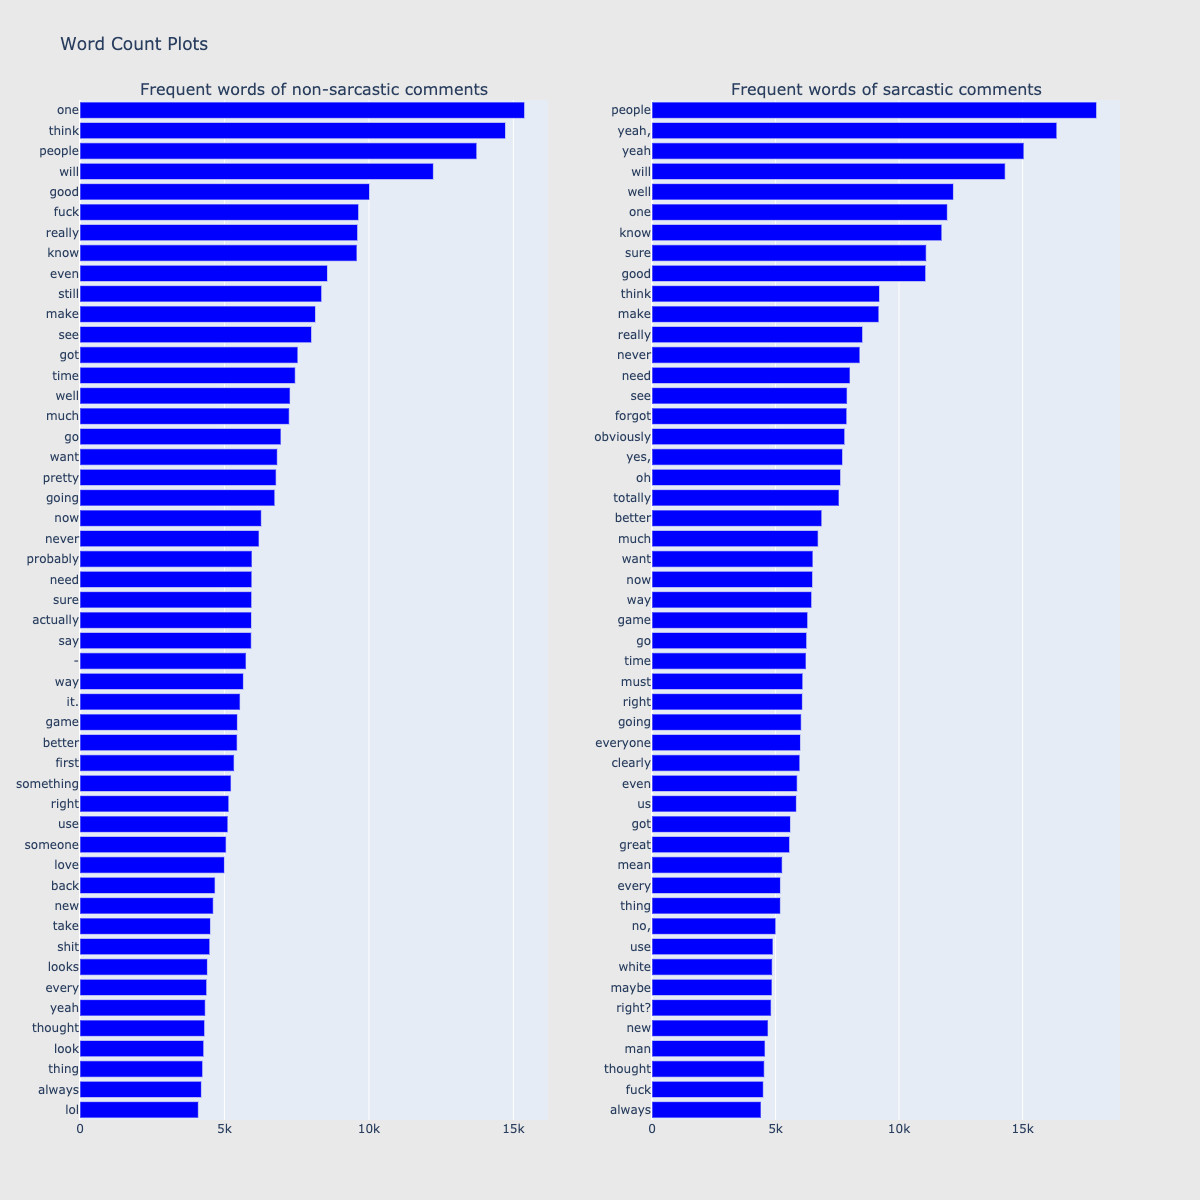

In [12]:
# github doesn't show the function output, the image was downloaded and showed explicitly
Image("frequent_words.png")

There are many words which are common across both classes like 'one', 'think', 'people', etc.
Doesn't give us much information.

Let's instead create bigram frequency plots for both the classes separately to get more idea.

In [13]:
show_most_frequent_words(data=train_df, column_text="comment", column_label="label", color="orange", num_words=2)

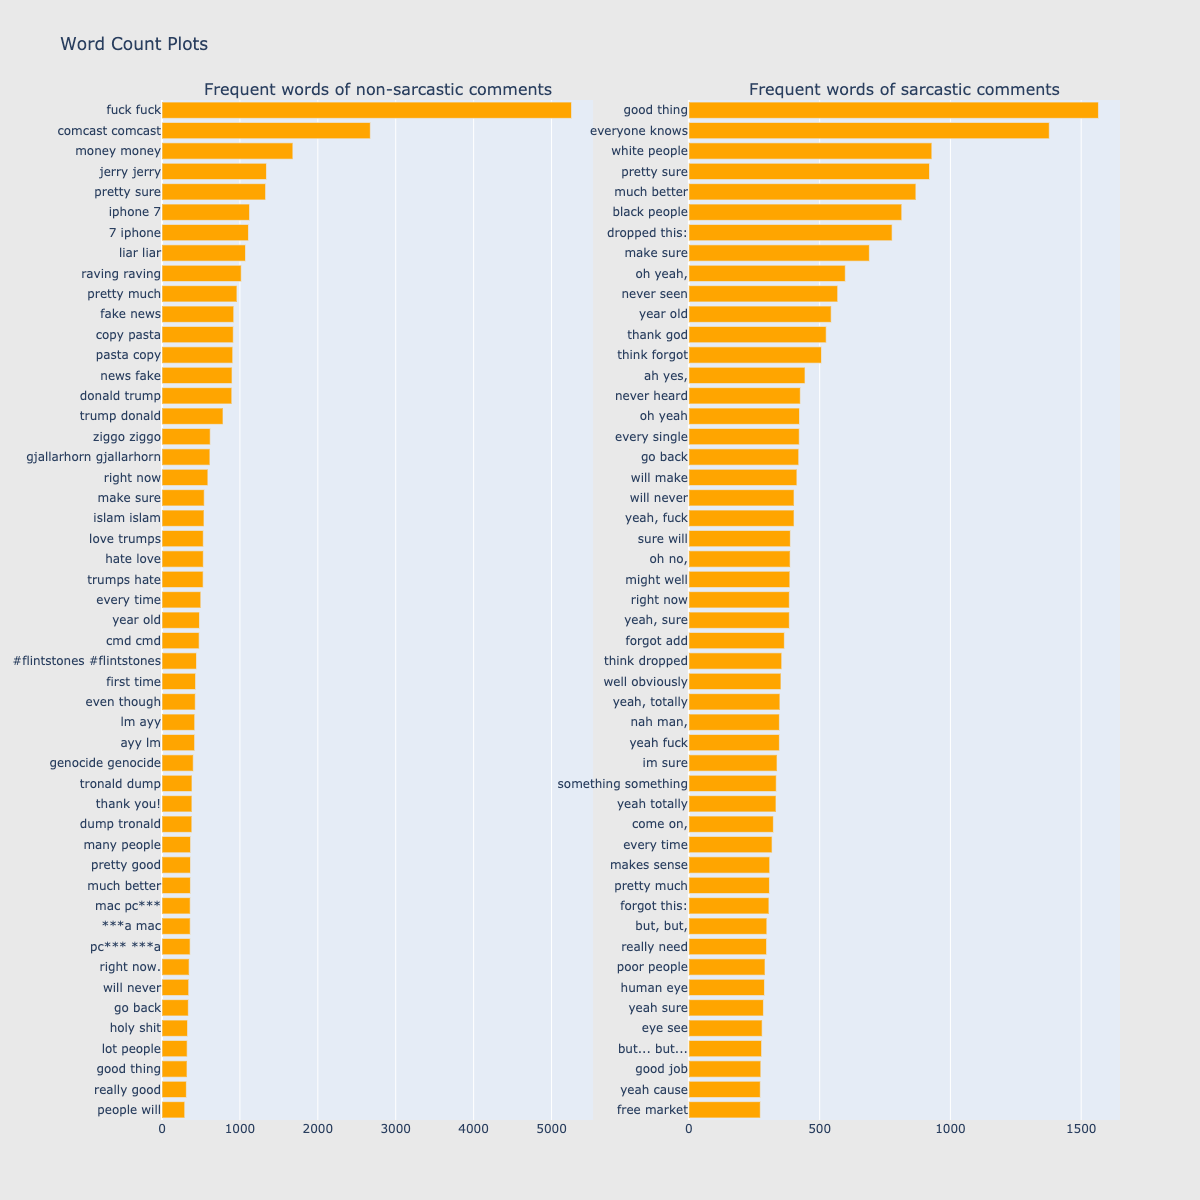

In [13]:
# github doesn't show the function output, the image was downloaded and showed explicitly
Image("frequent_bigrams.png")

We can see the difference, but not much. There are similarities presented as well: 'pretty sure', 'make sure', etc.

So let's look at the trigram plots.

In [14]:
show_most_frequent_words(data=train_df, column_text="comment", column_label="label", color="green", num_words=3)

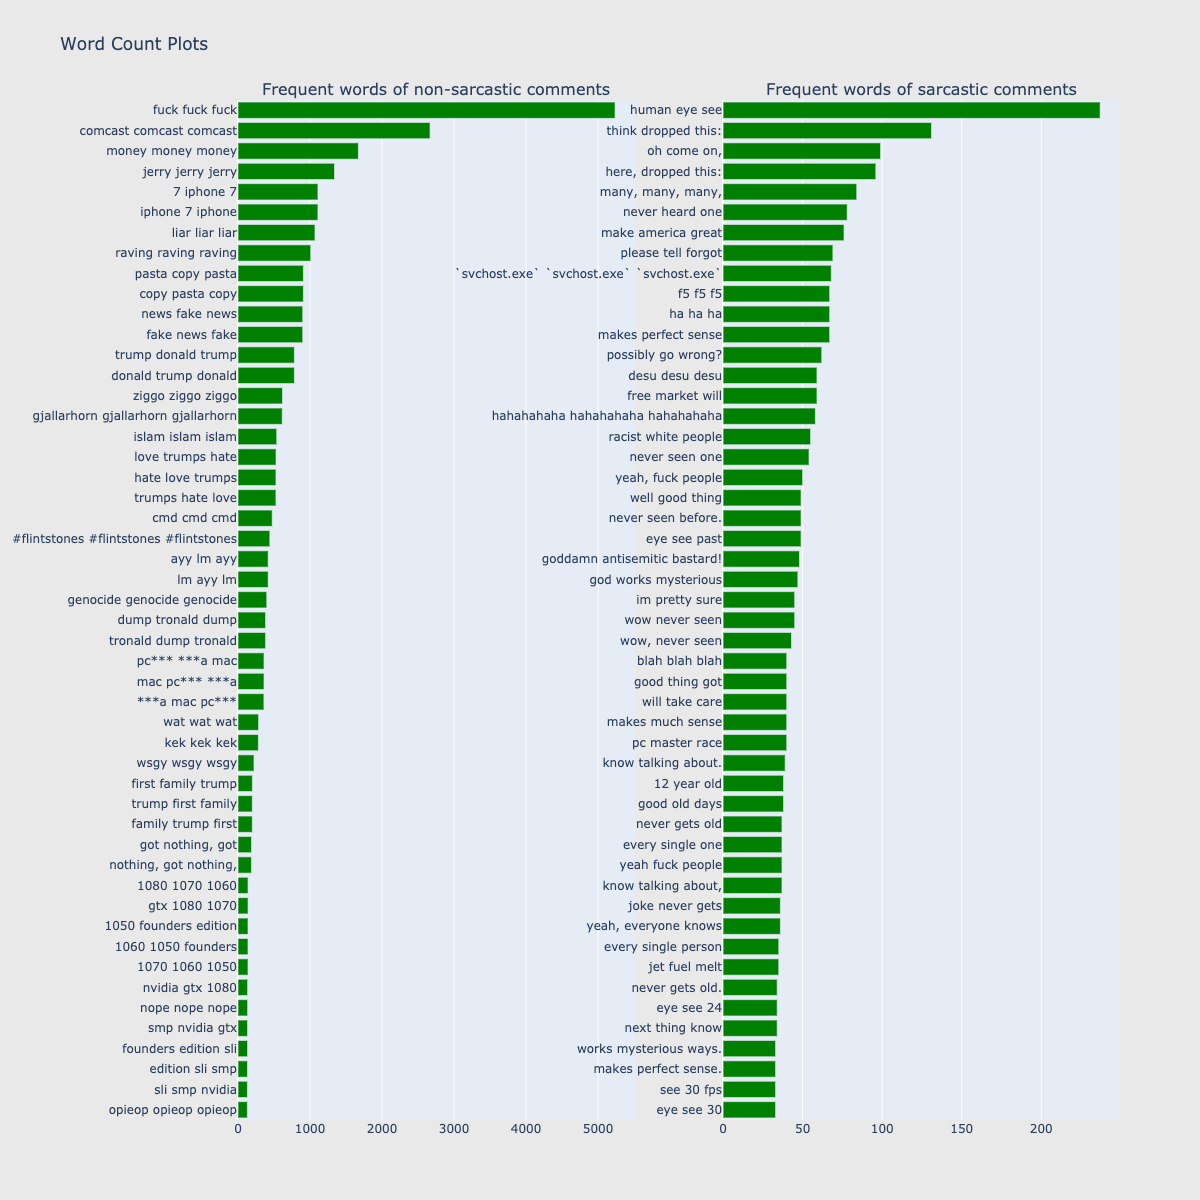

In [14]:
# github doesn't show the function output, the image was downloaded and showed explicitly
Image("frequent_trigrams.png")

Now we see clear difference between frequent words in each label. 

Non-sarcastic comments are mostly flood. Examples: 
- fuck fuck fuck
- money money money
- jerry jerry jerry

Sarcastic comments seem to use popular memes. Examples: 
- make america great [again!] 
- [what could] possibly go wrong?
- human eye see [24fps]
- desu desu desu
- here, dropeed this: [image of a clown mask]

---

In [15]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


Let's check another column 'subreddit'. <br>
We assume each subreddit topic may have different proportion of sarcastic comments in it. Let's see.

In [16]:
train_df["subreddit"].nunique()

14876

We have 14876 unique topics. <br>
We can't check proportion for all the topics. <br>
But we can choose the most popular ones [TOP 30], starting with at least 50 comments.

In [17]:
train_df['counts'] = train_df['subreddit'].map(train_df['subreddit'].value_counts())

In [18]:
popular_subreddits = train_df[train_df["counts"] > 50]
popular_subreddits = popular_subreddits.groupby("subreddit")["label"].describe()
popular_subreddits.sort_values(by="count", ascending=False).iloc[:30,:2]

,count,mean
subreddit,,
AskReddit,65674.0,0.401453
politics,39493.0,0.605348
worldnews,26376.0,0.642516
leagueoflegends,21034.0,0.542312
pcmasterrace,18987.0,0.566651
funny,17939.0,0.451474
news,16891.0,0.603457
pics,16152.0,0.484336
todayilearned,14159.0,0.547567


We see that depending on subreddit topic the mean value of sarcastic and non-sarcastic comments varies. <br>
For example:
- Askreddit: counts ~65000, of which ~40% are sarcastic.
- politics: counts ~40000, of which ~60% are sarcastic.
- worldnews: counts ~26000, of which ~64% are sarcastic.
- news: counts ~17000, of which ~60% are sarcastic.
- TumbIrInAction: counts ~7500, of which ~60% are sarcastic.
- creepyPMs: counts ~5400, of which ~78% are sarcastic.

The explanation may be that, 
- Askreddit - consists of many user's questions, which must be answered clearly, and sarcastic answer would be confusing. 
- politics, worldnews, news - political topics.
- TumbIrInAction, creepyPMs - consists of many screenshot pictures made for fun(joke), and may have fun(joke) responses in return. 

---

In [19]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,counts
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ...",39493
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...,14146
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.,14149
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz,1831
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...,1253


The columns 'author', 'ups', 'downs', 'date', 'created_utc' doesn't give us much information.

Let's check 'score' column.

In [20]:
sub_df = (
    train_df[train_df["score"] >= 0]
    .groupby("score")["label"]
    .agg([np.size, np.mean, np.sum])
)
sub_df[sub_df["size"] > 300].sort_values(by="mean", ascending=False).head(10)

,size,mean,sum
score,,,
0,58141,0.612752,35626
20,3096,0.561370,1738
34,1071,0.556489,596
26,1874,0.554429,1039
59,315,0.552381,174
18,3951,0.551759,2180
13,7277,0.546929,3980
17,4404,0.545867,2404
40,722,0.545706,394


In [21]:
sub_df = (
    train_df[train_df["score"] < 0]
    .groupby("score")["label"]
    .agg([np.size, np.mean, np.sum])
)
sub_df[sub_df["size"] > 300].sort_values(by="mean", ascending=False).head(10)

,size,mean,sum
score,,,
-14,537,0.698324,375
-8,1852,0.696004,1289
-9,1503,0.691284,1039
-6,3088,0.688795,2127
-12,776,0.684278,531
-5,4134,0.678520,2805
-3,6736,0.676069,4554
-2,11924,0.675948,8060
-4,5436,0.673473,3661


We can see that in both positive and negative scored comments there are more of sarcastic comments than non-sarcastic. <br>
In negative the count of sarcastic comments is higher than in positive.

By now, we observed 3 features we can work with. Let's train the model. <br>
We can start with only 'comment' column, and then add other columns to imporve accuracy.

---

## Training the model

In [24]:
train_texts, valid_texts, y_train, y_valid = train_test_split(
    train_df["comment"], train_df["label"], random_state=17
)

In [25]:
# build bigrams, put a limit on maximal number of features
# and minimal word frequency
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
# multinomial logistic regression a.k.a softmax classifier
logit = LogisticRegression(C=1, n_jobs=4, solver="lbfgs", random_state=17, verbose=1)
# putting all in Pipeline
tfidf_logit_pipeline = Pipeline([("tf_idf", tf_idf), ("logit", logit)])

In [26]:
%%time
tfidf_logit_pipeline.fit(train_texts, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


CPU times: user 29.1 s, sys: 470 ms, total: 29.6 s
Wall time: 42.1 s


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   12.6s finished


Pipeline(memory=None,
         steps=[('tf_idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=50000,
                                 min_df=2, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('logit',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scali

In [27]:
%%time
valid_pred = tfidf_logit_pipeline.predict(valid_texts)

CPU times: user 5.86 s, sys: 60.4 ms, total: 5.92 s
Wall time: 5.91 s


In [28]:
accuracy_score(y_valid, valid_pred)

0.7207215050614577

0.72072 is our baseline. 

## Understanding the model

In [29]:
def plot_confusion_matrix(
    actual,
    predicted,
    classes,
    normalize=False,
    title="Confusion matrix",
    figsize=(7, 7),
    cmap=plt.cm.Blues,
    path_to_save_fig=None,
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools

    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(actual, predicted).T
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("Predicted label")
    plt.xlabel("True label")

    if path_to_save_fig:
        plt.savefig(path_to_save_fig, dpi=300, bbox_inches="tight")

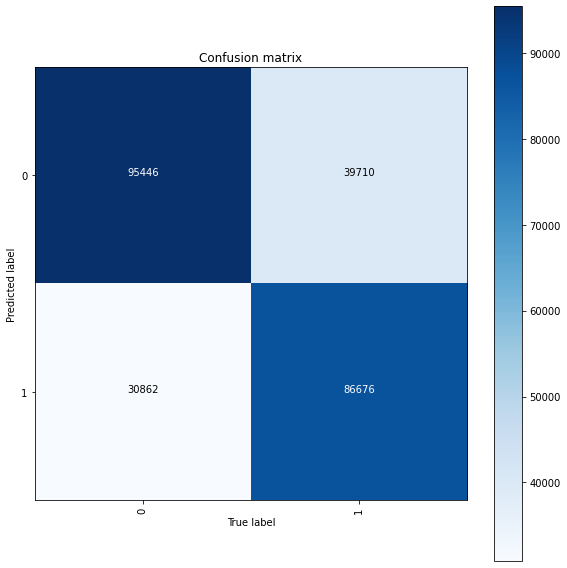

In [30]:
plot_confusion_matrix(
    y_valid,
    valid_pred,
    tfidf_logit_pipeline.named_steps["logit"].classes_,
    figsize=(8, 8),
)

Confusion matrix is quite balanced.

In [31]:
import eli5

eli5.show_weights(
    estimator=tfidf_logit_pipeline.named_steps["logit"],
    vec=tfidf_logit_pipeline.named_steps["tf_idf"],
)

Weight?,Feature
+9.696,yes because
+7.940,clearly
+7.408,obviously
+7.407,yeah because
+6.890,totally
+6.345,because
+5.966,how dare
+5.876,right because
+5.586,but thought
+5.256,duh


We can see the top features. We can interpret them as indicators of sarcastic expressions. <br> 
Most of them have meaning of "yes, sure", which is used as or before a sarcastic statement.

## Improving the model

In [32]:
subreddits = train_df["subreddit"]
train_subreddits, valid_subreddits = train_test_split(subreddits, random_state=17)

We'll have separate Tf-Idf vectorizers for comments and for subreddits. It's possible to stick to a pipeline as well, but in that case it becomes a bit less straightforward.

In [33]:
tf_idf_texts = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
tf_idf_subreddits = TfidfVectorizer(ngram_range=(1, 1))

Do transformations separately for comments and subreddits.

In [34]:
%%time
X_train_texts = tf_idf_texts.fit_transform(train_texts)
X_valid_texts = tf_idf_texts.transform(valid_texts)

CPU times: user 37.9 s, sys: 1 s, total: 38.9 s
Wall time: 38.8 s


In [35]:
X_train_texts.shape, X_valid_texts.shape

((758079, 50000), (252694, 50000))

In [36]:
%%time
X_train_subreddits = tf_idf_subreddits.fit_transform(train_subreddits)
X_valid_subreddits = tf_idf_subreddits.transform(valid_subreddits)

CPU times: user 3.5 s, sys: 16.4 ms, total: 3.52 s
Wall time: 3.52 s


In [37]:
X_train_subreddits.shape, X_valid_subreddits.shape

((758079, 13255), (252694, 13255))

Stack all features together.

In [38]:
from scipy.sparse import hstack

X_train = hstack([X_train_texts, X_train_subreddits])
X_valid = hstack([X_valid_texts, X_valid_subreddits])

In [39]:
X_train.shape, X_valid.shape

((758079, 63255), (252694, 63255))

Train the same logistic regression.

In [40]:
logit.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   13.4s finished


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=4, penalty='l2', random_state=17,
                   solver='lbfgs', tol=0.0001, verbose=1, warm_start=False)

In [41]:
%%time
valid_pred = logit.predict(X_valid)

CPU times: user 93.6 ms, sys: 1.05 ms, total: 94.7 ms
Wall time: 97.9 ms


In [42]:
accuracy_score(y_valid, valid_pred)

0.7237844982468915

As we can see, accuracy slightly increased.